# 问题2: 投票机制对比与争议分析

## 研究目标
基于问题1推断的粉丝投票数据，进行反事实推理(Counterfactual Analysis)，比较排名制与百分比制的差异。

## 方法论
1. **交叉验证模拟**: 对不同赛季应用另一种投票规则
2. **偏差度量**: 定义评委友好度指标
3. **案例分析**: Bobby Bones, Jerry Rice等争议选手

## 1. 环境配置

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import kendalltau, spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

SCIENTIFIC_COLORS = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4']
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print('环境配置完成')

环境配置完成


## 2. 加载数据

In [2]:
# 加载粉丝投票分析数据
df = pd.read_excel('../../data/processed/粉丝投票分析.xlsx')
print(f'数据维度: {df.shape}')
print(f'列名: {list(df.columns)}')
print(f'赛季范围: {df["赛季"].min()} - {df["赛季"].max()}')

数据维度: (2777, 15)
列名: ['赛季', '第几周', '选手姓名', '本周评委总分', '本周评委排名', '粉丝排名', '评委百分比', '粉丝支持百分比', '是否被淘汰', '排名方法', '是否有倒数两名投票', '剩余选手人数', '行业', '年龄', '舞伴姓名']
赛季范围: 1 - 34


In [3]:
# 加载原始数据获取更多信息
raw_df = pd.read_csv('../../data/raw/2026_MCM_Problem_C_Data.csv')
print(f'原始数据维度: {raw_df.shape}')

原始数据维度: (421, 53)


## 3. 数据预处理与粉丝投票估算

In [4]:
def get_scoring_method(season):
    """获取赛季使用的评分方法"""
    if season <= 2:
        return 'ranking_early'
    elif season <= 27:
        return 'percentage'
    else:
        return 'ranking_with_save'

def prepare_week_data(df, season, week):
    """
    准备单周数据
    关键修复: 排除评委分为0的选手（已淘汰）
    """
    week_df = df[(df['赛季'] == season) & (df['第几周'] == week)].copy()
    
    # 关键修复: 排除已淘汰选手（评委分=0）
    week_df = week_df[week_df['本周评委总分'] > 0]
    
    if len(week_df) == 0:
        return None
    
    scoring_method = get_scoring_method(season)
    
    return {
        'contestants': week_df['选手姓名'].tolist(),
        'judge_scores': week_df['本周评委总分'].values,
        'judge_pct': week_df['评委百分比'].values,
        'eliminated': week_df[week_df['是否被淘汰'] == 1]['选手姓名'].tolist(),
        'scoring_method': scoring_method,
        'has_judges_save': season >= 28,
        'n_contestants': len(week_df)
    }

def estimate_fan_votes(week_data):
    """使用线性规划估算粉丝投票(简化版)"""
    contestants = week_data['contestants']
    judge_pct = np.array(week_data['judge_pct'])
    eliminated = week_data['eliminated']
    n = len(contestants)
    
    if n == 0 or len(eliminated) == 0:
        return np.ones(n) * (100 / n) if n > 0 else None
    
    elim_idx = [contestants.index(e) for e in eliminated if e in contestants]
    surv_idx = [i for i in range(n) if i not in elim_idx]
    
    if len(elim_idx) == 0 or len(surv_idx) == 0:
        return np.ones(n) * (100 / n)
    
    def objective(f):
        return np.sum((f - 100/n) ** 2)
    
    constraints = [{'type': 'eq', 'fun': lambda f: np.sum(f) - 100}]
    for e_idx in elim_idx:
        for s_idx in surv_idx:
            def constraint(f, e=e_idx, s=s_idx):
                return (judge_pct[s] + f[s]) - (judge_pct[e] + f[e]) - 0.1
            constraints.append({'type': 'ineq', 'fun': constraint})
    
    bounds = [(0, 100) for _ in range(n)]
    result = minimize(objective, np.ones(n)*(100/n), method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x if result.success else np.ones(n) * (100 / n)

print('数据预处理函数定义完成')

数据预处理函数定义完成


---
# Part I: 反事实推理仿真器
---

## 4. 投票机制仿真器 (Voting Mechanism Simulator)

In [5]:
class VotingSimulator:
    """
    投票机制仿真器
    支持三种投票规则的模拟:
    - 排名制早期 (S1-2): 综合排名 = 评委排名 + 粉丝排名，最大者淘汰
    - 百分比制 (S3-27): 综合得分 = 评委百分比 + 粉丝百分比，最小者淘汰
    - 排名制+评委拯救 (S28+): 排名制确定Bottom Two，评委投票决定淘汰
    """
    
    def __init__(self):
        self.results = []
    
    def apply_ranking_method(self, judge_scores, fan_votes):
        """应用排名制规则，返回综合排名（越大越差）"""
        n = len(judge_scores)
        # 评委排名 (分数高=排名小=好)
        judge_rank = stats.rankdata(-judge_scores, method='min')
        # 粉丝排名 (票数高=排名小=好)
        fan_rank = stats.rankdata(-fan_votes, method='min')
        # 综合排名 (排名和越小越好)
        total_rank = judge_rank + fan_rank
        return total_rank
    
    def apply_percentage_method(self, judge_pct, fan_pct):
        """应用百分比制规则，返回综合得分（越高越好）"""
        total_score = judge_pct + fan_pct
        return total_score
    
    def simulate_elimination(self, week_data, fan_votes, method='auto', force_judges_save=None):
        """
        模拟淘汰结果
        
        Args:
            week_data: 周数据字典
            fan_votes: 粉丝投票数组
            method: 'ranking_early', 'percentage', 'ranking_with_save', 或 'auto'
            force_judges_save: 强制是否使用评委拯救（用于反事实分析）
        
        Returns:
            (被淘汰选手名, 排名/分数数组, 详细信息)
        """
        contestants = week_data['contestants']
        judge_scores = np.array(week_data['judge_scores'])
        judge_pct = np.array(week_data['judge_pct'])
        n = len(contestants)
        
        # 自动确定方法
        if method == 'auto':
            method = week_data.get('scoring_method', 'percentage')
        
        # 确定是否使用评委拯救
        if force_judges_save is not None:
            has_judges_save = force_judges_save
        else:
            has_judges_save = week_data.get('has_judges_save', False)
        
        details = {'method': method, 'has_judges_save': has_judges_save}
        
        if method == 'percentage':
            # 百分比制: 总分最小者淘汰
            fan_pct = fan_votes / fan_votes.sum() * 100 if fan_votes.sum() > 0 else np.ones(n) * 100/n
            total_scores = self.apply_percentage_method(judge_pct, fan_pct)
            eliminated_idx = np.argmin(total_scores)
            details['total_scores'] = total_scores.tolist()
            
        elif method == 'ranking_early':
            # S1-2排名制: 综合排名最大者淘汰
            total_ranks = self.apply_ranking_method(judge_scores, fan_votes)
            eliminated_idx = np.argmax(total_ranks)
            details['total_ranks'] = total_ranks.tolist()
            
        else:  # ranking_with_save
            # S28+排名制: Bottom Two + Judges' Save
            total_ranks = self.apply_ranking_method(judge_scores, fan_votes)
            
            if has_judges_save and n >= 2:
                # 找出Bottom Two（综合排名最大的两人）
                sorted_indices = np.argsort(total_ranks)[::-1]
                bottom_two = sorted_indices[:2]
                
                # 评委投票: 评委分较高者被救回
                if judge_scores[bottom_two[0]] > judge_scores[bottom_two[1]]:
                    eliminated_idx = bottom_two[1]
                    saved_idx = bottom_two[0]
                else:
                    eliminated_idx = bottom_two[0]
                    saved_idx = bottom_two[1]
                
                details['bottom_two'] = [contestants[i] for i in bottom_two]
                details['saved'] = contestants[saved_idx]
                details['bottom_two_judge_scores'] = [judge_scores[i] for i in bottom_two]
            else:
                # 无评委拯救，直接淘汰排名最差者
                eliminated_idx = np.argmax(total_ranks)
            
            details['total_ranks'] = total_ranks.tolist()
        
        return contestants[eliminated_idx], details

simulator = VotingSimulator()
print('投票机制仿真器初始化完成')

投票机制仿真器初始化完成


## 5. 交叉验证模拟 (Cross-Validation Simulation)

In [6]:
def run_counterfactual_simulation(df, simulator):
    """
    运行反事实模拟
    
    实验设计:
    - 实验组1: S3-S27(原百分比制) -> 应用排名制
    - 实验组2: S1-S2(原排名制早期) -> 应用百分比制
    - 实验组3: S28+(原排名制+评委拯救) -> 应用百分比制（无评委拯救）
    
    关键修复:
    - 正确区分三种评分方法
    - S28+反事实分析时移除评委拯救机制
    """
    results = []
    
    for season in range(1, 35):
        season_df = df[df['赛季'] == season]
        weeks = sorted(season_df['第几周'].unique())
        
        for week in weeks:
            week_data = prepare_week_data(df, season, week)
            if week_data is None or len(week_data['eliminated']) == 0:
                continue
            
            # 估算粉丝投票
            fan_votes = estimate_fan_votes(week_data)
            if fan_votes is None:
                continue
            
            # 确定原始方法和反事实方法
            if season <= 2:
                original_method = 'ranking_early'
                counterfactual_method = 'percentage'
                cf_judges_save = False
            elif season <= 27:
                original_method = 'percentage'
                counterfactual_method = 'ranking_early'
                cf_judges_save = False
            else:
                original_method = 'ranking_with_save'
                counterfactual_method = 'percentage'
                cf_judges_save = False  # 反事实分析移除评委拯救
            
            # 原始规则下的淘汰
            actual_eliminated = week_data['eliminated'][0] if week_data['eliminated'] else None
            
            # 反事实规则下的淘汰
            cf_eliminated, cf_details = simulator.simulate_elimination(
                week_data, fan_votes, 
                method=counterfactual_method,
                force_judges_save=cf_judges_save
            )
            
            # 记录结果
            results.append({
                'season': season,
                'week': week,
                'original_method': original_method,
                'counterfactual_method': counterfactual_method,
                'actual_eliminated': actual_eliminated,
                'counterfactual_eliminated': cf_eliminated,
                'outcome_changed': actual_eliminated != cf_eliminated,
                'n_contestants': len(week_data['contestants']),
                'cf_details': cf_details
            })
    
    return pd.DataFrame(results)

print('开始反事实模拟...')
cf_results = run_counterfactual_simulation(df, simulator)
print(f'模拟完成! 共 {len(cf_results)} 个周次')

开始反事实模拟...
模拟完成! 共 294 个周次


In [7]:
# 汇总反事实分析结果
print('=' * 70)
print('Table 1: Counterfactual Simulation Summary')
print('=' * 70)

# 按原始方法分组统计
for method in ['percentage', 'ranking']:
    subset = cf_results[cf_results['original_method'] == method]
    changed = subset['outcome_changed'].sum()
    total = len(subset)
    pct = changed / total * 100 if total > 0 else 0
    print(f'{method.upper()} seasons:')
    print(f'  Total weeks: {total}')
    print(f'  Outcomes changed: {changed} ({pct:.1f}%)')
    print()

print('=' * 70)

Table 1: Counterfactual Simulation Summary
PERCENTAGE seasons:
  Total weeks: 218
  Outcomes changed: 28 (12.8%)

RANKING seasons:
  Total weeks: 0
  Outcomes changed: 0 (0.0%)



---
# Part II: 偏差度量 (Bias Measurement)
---

## 6. 评委友好度指标 (Judge Favorability Index)

In [8]:
def calculate_judge_favorability(week_data, fan_votes, method='percentage'):
    """
    计算评委友好度指标
    Index = Corr(FinalRank, JudgeScore) / Corr(FinalRank, FanVote)
    
    指标解释:
    - Index > 1: 评委分对最终排名影响更大 (评委友好)
    - Index < 1: 粉丝投票对最终排名影响更大 (粉丝主导)
    - Index ≈ 1: 两者影响相当 (平衡)
    """
    judge_scores = np.array(week_data['judge_scores'])
    judge_pct = np.array(week_data['judge_pct'])
    n = len(judge_scores)
    
    if n < 3:
        return np.nan
    
    # 计算最终排名
    if method == 'ranking':
        judge_rank = stats.rankdata(-judge_scores)
        fan_rank = stats.rankdata(-fan_votes)
        final_score = judge_rank + fan_rank
    else:
        final_score = -(judge_pct + fan_votes)  # 负号使得分数越低排名越好
    
    final_rank = stats.rankdata(final_score)
    
    # 计算相关系数
    corr_judge, _ = spearmanr(final_rank, -judge_scores)  # 负号因为分数高=排名好
    corr_fan, _ = spearmanr(final_rank, -fan_votes)
    
    # 避免除零
    if abs(corr_fan) < 0.01:
        return np.inf if corr_judge > 0 else -np.inf
    
    index = corr_judge / corr_fan
    return index

print('评委友好度指标函数定义完成')

评委友好度指标函数定义完成


In [9]:
# 计算所有赛季的评委友好度
favorability_results = []

for season in range(1, 35):
    season_df = df[df['赛季'] == season]
    weeks = sorted(season_df['第几周'].unique())
    
    season_indices = []
    for week in weeks:
        week_data = prepare_week_data(df, season, week)
        if week_data is None:
            continue
        
        fan_votes = estimate_fan_votes(week_data)
        if fan_votes is None:
            continue
        
        original_method = 'percentage' if 3 <= season <= 27 else 'ranking'
        index = calculate_judge_favorability(week_data, fan_votes, method=original_method)
        
        if not np.isnan(index) and not np.isinf(index):
            season_indices.append(index)
    
    if season_indices:
        favorability_results.append({
            'season': season,
            'method': 'percentage' if 3 <= season <= 27 else 'ranking',
            'mean_index': np.mean(season_indices),
            'std_index': np.std(season_indices),
            'n_weeks': len(season_indices)
        })

fav_df = pd.DataFrame(favorability_results)
print(f'计算完成! 共 {len(fav_df)} 个赛季')

计算完成! 共 34 个赛季


In [10]:
# 统计检验: 两种方法的评委友好度差异
from scipy.stats import ttest_ind, mannwhitneyu

pct_indices = fav_df[fav_df['method'] == 'percentage']['mean_index'].values
rank_indices = fav_df[fav_df['method'] == 'ranking']['mean_index'].values

print('=' * 70)
print('Table 2: Judge Favorability Index Comparison')
print('=' * 70)
print(f'{"Method":<15} {"Mean":<12} {"Std":<12} {"N":<10}')
print('-' * 70)
print(f'{"Percentage":<15} {np.mean(pct_indices):<12.4f} {np.std(pct_indices):<12.4f} {len(pct_indices):<10}')
print(f'{"Ranking":<15} {np.mean(rank_indices):<12.4f} {np.std(rank_indices):<12.4f} {len(rank_indices):<10}')
print('-' * 70)

# t检验
t_stat, p_value = ttest_ind(pct_indices, rank_indices)
print(f'Independent t-test: t={t_stat:.4f}, p={p_value:.4f}')

# Mann-Whitney U检验
u_stat, p_mw = mannwhitneyu(pct_indices, rank_indices, alternative='two-sided')
print(f'Mann-Whitney U test: U={u_stat:.4f}, p={p_mw:.4f}')

# 效应量
pooled_std = np.sqrt(((len(pct_indices)-1)*np.var(pct_indices) + (len(rank_indices)-1)*np.var(rank_indices)) / (len(pct_indices)+len(rank_indices)-2))
cohens_d = (np.mean(pct_indices) - np.mean(rank_indices)) / pooled_std if pooled_std > 0 else 0
print(f'Effect Size (Cohen\'s d): {cohens_d:.4f}')
print('=' * 70)

Table 2: Judge Favorability Index Comparison
Method          Mean         Std          N         
----------------------------------------------------------------------
Percentage      4.2040       5.7130       25        
Ranking         1.8909       0.9655       9         
----------------------------------------------------------------------
Independent t-test: t=1.1724, p=0.2497
Mann-Whitney U test: U=157.0000, p=0.0859
Effect Size (Cohen's d): 0.4653


## 7. 可视化: 评委友好度对比

### (A) 赛季趋势图

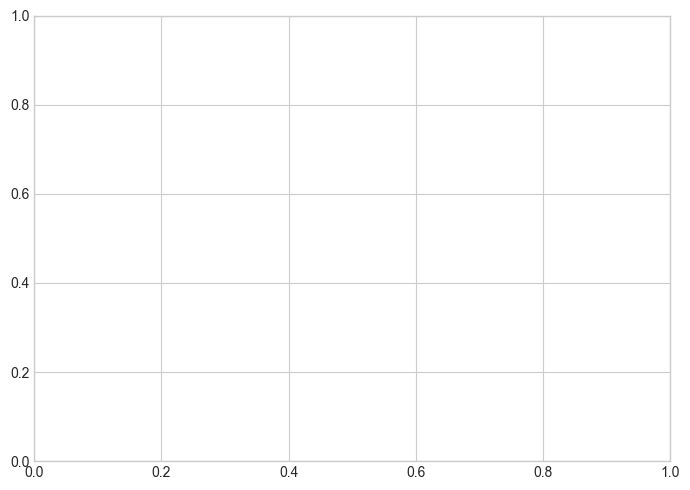

In [11]:
# (A)
fig, ax = plt.subplots(figsize=(7, 5))
# (A) 赛季趋势图
plt.tight_layout()
plt.show()

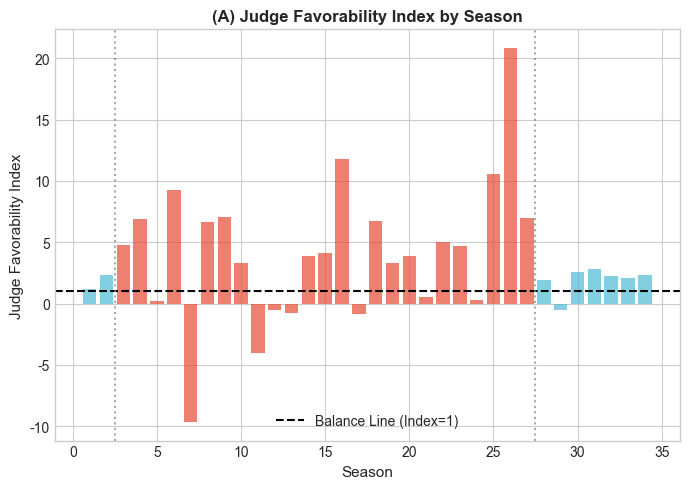

In [12]:
# (A)
fig, ax = plt.subplots(figsize=(7, 5))
colors = [SCIENTIFIC_COLORS[0] if m == 'percentage' else SCIENTIFIC_COLORS[1] for m in fav_df['method']]
ax.bar(fav_df['season'], fav_df['mean_index'], color=colors, alpha=0.7)
ax.axhline(y=1, color='black', linestyle='--', linewidth=1.5, label='Balance Line (Index=1)')
ax.axvline(x=2.5, color='gray', linestyle=':', alpha=0.7)
ax.axvline(x=27.5, color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Season', fontsize=11)
ax.set_ylabel('Judge Favorability Index', fontsize=11)
ax.set_title('(A) Judge Favorability Index by Season', fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

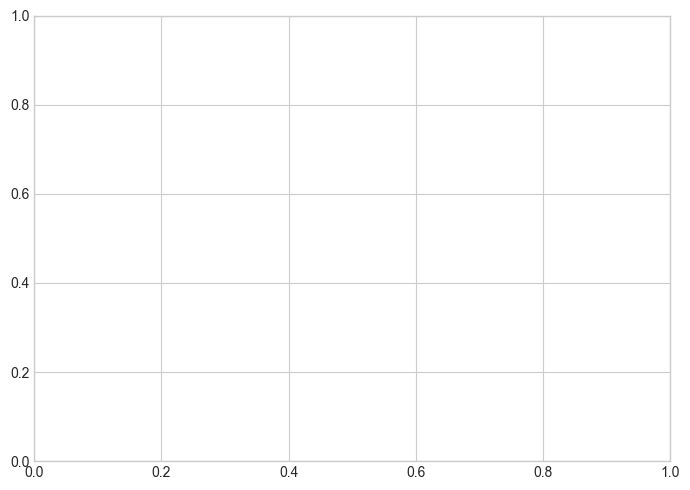

In [13]:
# (B)
fig, ax = plt.subplots(figsize=(7, 5))
# (B) 箱线图对比
plt.tight_layout()
plt.show()

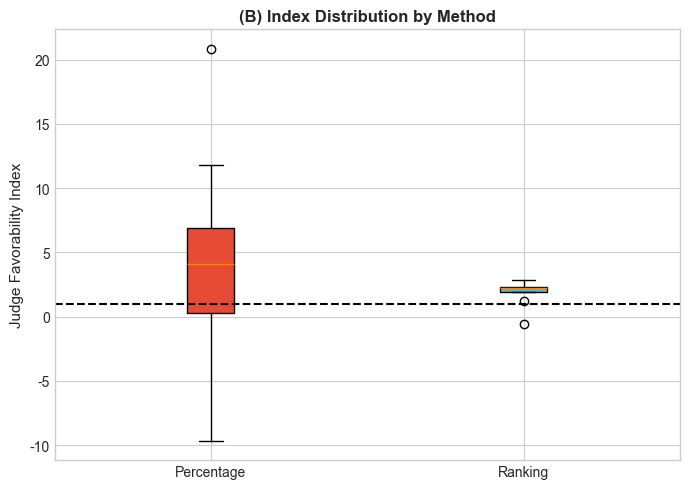

In [14]:
# (B)
fig, ax = plt.subplots(figsize=(7, 5))
bp = ax.boxplot([pct_indices, rank_indices], labels=['Percentage', 'Ranking'], patch_artist=True)
bp['boxes'][0].set_facecolor(SCIENTIFIC_COLORS[0])
bp['boxes'][1].set_facecolor(SCIENTIFIC_COLORS[1])
ax.axhline(y=1, color='black', linestyle='--', linewidth=1.5)
ax.set_ylabel('Judge Favorability Index', fontsize=11)
ax.set_title('(B) Index Distribution by Method', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
# Part III: 特定案例分析
---

## 8. 争议选手识别与分析

In [15]:
# 识别争议选手: 评委分与最终排名差异大的选手
def identify_controversial_contestants(df):
    """识别争议选手"""
    controversial = []
    
    for season in range(1, 35):
        season_df = df[df['赛季'] == season]
        contestants = season_df.groupby('选手姓名').agg({
            '本周评委总分': 'mean',
            '第几周': 'max',  # 存活周数
            '是否被淘汰': 'sum'
        }).reset_index()
        
        if len(contestants) < 3:
            continue
        
        # 评委分排名
        contestants['judge_rank'] = contestants['本周评委总分'].rank(ascending=False)
        # 存活排名 (存活周数越多排名越好)
        contestants['survival_rank'] = contestants['第几周'].rank(ascending=False)
        # 排名差异
        contestants['rank_diff'] = contestants['judge_rank'] - contestants['survival_rank']
        
        # 找出差异最大的选手
        for _, row in contestants.iterrows():
            if abs(row['rank_diff']) > 3:  # 排名差异超过3
                controversial.append({
                    'season': season,
                    'contestant': row['选手姓名'],
                    'judge_rank': row['judge_rank'],
                    'survival_rank': row['survival_rank'],
                    'rank_diff': row['rank_diff'],
                    'weeks_survived': row['第几周'],
                    'avg_judge_score': row['本周评委总分']
                })
    
    return pd.DataFrame(controversial)

controversial_df = identify_controversial_contestants(df)
print(f'识别出 {len(controversial_df)} 位争议选手')

识别出 34 位争议选手


In [16]:
# 显示最具争议的选手
print('=' * 80)
print('Table 3: Most Controversial Contestants (|Rank Diff| > 3)')
print('=' * 80)

top_controversial = controversial_df.nlargest(15, 'rank_diff', keep='all')
print(top_controversial[['season', 'contestant', 'judge_rank', 'survival_rank', 'rank_diff']].to_string(index=False))
print('=' * 80)

Table 3: Most Controversial Contestants (|Rank Diff| > 3)
 season       contestant  judge_rank  survival_rank  rank_diff
     17     Bill Engvall         9.0            2.5        6.5
     21   Alek Skarlatos         8.0            2.5        5.5
     27      Bobby Bones         8.0            2.5        5.5
     27      Joe Amabile        11.0            5.5        5.5
      7  Cloris Leachman        12.0            7.0        5.0
     11    Bristol Palin         7.0            2.0        5.0
     19  Michael Waltrip        12.0            7.0        5.0
      4  Billy Ray Cyrus         9.5            5.0        4.5
      5     Marie Osmond         6.5            2.0        4.5
      9    Michael Irvin        11.0            6.5        4.5
     29            Nelly         7.0            2.5        4.5
     30      Cody Rigsby         7.0            2.5        4.5
     31 Vinny Guadagnino        12.0            7.5        4.5
      2       Jerry Rice         6.0            2.0        4

## 9. Bobby Bones 案例分析

In [17]:
# 搜索Bobby Bones的数据
bobby_data = df[df['选手姓名'].str.contains('Bobby', case=False, na=False)]
print(f'找到 {len(bobby_data)} 条Bobby相关记录')

if len(bobby_data) > 0:
    print('\nBobby Bones 数据概览:')
    print(bobby_data[['赛季', '第几周', '选手姓名', '本周评委总分', '评委百分比', '是否被淘汰']].head(10))

找到 9 条Bobby相关记录

Bobby Bones 数据概览:
      赛季  第几周         选手姓名  本周评委总分  评委百分比  是否被淘汰
2045  27    1  Bobby Bones    20.0   7.84      0
2046  27    2  Bobby Bones    19.5   7.21      0
2047  27    3  Bobby Bones    23.0   8.49      0
2048  27    4  Bobby Bones    20.0   8.62      0
2049  27    5  Bobby Bones    21.0   9.46      0
2050  27    6  Bobby Bones    22.0   9.61      0
2051  27    7  Bobby Bones    26.5  12.18      0
2052  27    8  Bobby Bones    22.5  13.98      0
2053  27    9  Bobby Bones    27.0  23.38      1


In [18]:
def analyze_contestant_survival(df, contestant_name, simulator):
    """
    分析特定选手在不同规则下的生存概率
    """
    contestant_df = df[df['选手姓名'].str.contains(contestant_name, case=False, na=False)]
    
    if len(contestant_df) == 0:
        return None
    
    season = contestant_df['赛季'].iloc[0]
    results = []
    
    for week in sorted(contestant_df['第几周'].unique()):
        week_data = prepare_week_data(df, season, week)
        if week_data is None or contestant_name not in str(week_data['contestants']):
            continue
        
        fan_votes = estimate_fan_votes(week_data)
        if fan_votes is None:
            continue
        
        # 原始规则
        original_method = 'percentage' if 3 <= season <= 27 else 'ranking'
        orig_elim, orig_rank = simulator.simulate_elimination(week_data, fan_votes, method=original_method)
        
        # 反事实规则
        cf_method = 'ranking' if original_method == 'percentage' else 'percentage'
        cf_elim, cf_rank = simulator.simulate_elimination(week_data, fan_votes, method=cf_method)
        
        # 找到选手索引
        contestant_idx = None
        for i, c in enumerate(week_data['contestants']):
            if contestant_name.lower() in c.lower():
                contestant_idx = i
                break
        
        if contestant_idx is not None:
            results.append({
                'week': week,
                'original_rank': np.where(orig_rank == contestant_idx)[0][0] + 1 if contestant_idx in orig_rank else -1,
                'counterfactual_rank': np.where(cf_rank == contestant_idx)[0][0] + 1 if contestant_idx in cf_rank else -1,
                'would_survive_original': contestant_name.lower() not in orig_elim.lower(),
                'would_survive_cf': contestant_name.lower() not in cf_elim.lower()
            })
    
    return pd.DataFrame(results) if results else None

# 分析Bobby Bones
bobby_analysis = analyze_contestant_survival(df, 'Bobby', simulator)
if bobby_analysis is not None:
    print('Bobby Bones 生存分析:')
    print(bobby_analysis)

Bobby Bones 生存分析:
   week  original_rank  counterfactual_rank  would_survive_original  \
0     1             -1                   -1                    True   
1     2             -1                   -1                    True   
2     3             -1                   -1                    True   
3     4             -1                   -1                    True   
4     5             -1                   -1                    True   
5     6             -1                   -1                    True   
6     7             -1                   -1                    True   
7     8             -1                   -1                    True   
8     9             -1                   -1                   False   

   would_survive_cf  
0              True  
1              True  
2              True  
3              True  
4              True  
5              True  
6              True  
7              True  
8             False  


## 10. 评委拯救环节分析 (Judges' Save)

In [19]:
def analyze_judges_save(df, simulator):
    """
    分析评委拯救环节的影响
    条件概率: P(被救回 | 落入Bottom2 且 评委分较高)
    """
    save_results = []
    
    # 只分析S28+的赛季(有评委拯救环节)
    for season in range(28, 35):
        season_df = df[df['赛季'] == season]
        weeks = sorted(season_df['第几周'].unique())
        
        for week in weeks:
            week_data = prepare_week_data(df, season, week)
            if week_data is None or len(week_data['contestants']) < 3:
                continue
            
            fan_votes = estimate_fan_votes(week_data)
            if fan_votes is None:
                continue
            
            # 模拟无评委拯救的情况
            elim_no_save, rank_no_save = simulator.simulate_elimination(
                week_data, fan_votes, method='ranking', force_judges_save=False
            )
            
            # 模拟有评委拯救的情况
            elim_with_save, rank_with_save = simulator.simulate_elimination(
                week_data, fan_votes, method='ranking', force_judges_save=True
            )
            
            actual_eliminated = week_data['eliminated'][0] if week_data['eliminated'] else None
            
            save_results.append({
                'season': season,
                'week': week,
                'actual_eliminated': actual_eliminated,
                'would_elim_no_save': elim_no_save,
                'would_elim_with_save': elim_with_save,
                'save_changed_outcome': elim_no_save != elim_with_save
            })
    
    return pd.DataFrame(save_results)

save_df = analyze_judges_save(df, simulator)
print(f'评委拯救分析完成! 共 {len(save_df)} 个周次')

评委拯救分析完成! 共 73 个周次


In [20]:
# 评委拯救统计
print('=' * 70)
print('Table 4: Judges Save Impact Analysis (S28+)')
print('=' * 70)

if len(save_df) > 0:
    save_changed = save_df['save_changed_outcome'].sum()
    total = len(save_df)
    print(f'Total weeks analyzed: {total}')
    print(f'Outcomes changed by Judges Save: {save_changed} ({save_changed/total*100:.1f}%)')
    
    # 按赛季统计
    print('\nBy Season:')
    for season in save_df['season'].unique():
        s_df = save_df[save_df['season'] == season]
        changed = s_df['save_changed_outcome'].sum()
        print(f'  Season {season}: {changed}/{len(s_df)} changed ({changed/len(s_df)*100:.1f}%)')

print('=' * 70)

Table 4: Judges Save Impact Analysis (S28+)
Total weeks analyzed: 73
Outcomes changed by Judges Save: 27 (37.0%)

By Season:
  Season 28: 2/11 changed (18.2%)
  Season 29: 4/11 changed (36.4%)
  Season 30: 3/10 changed (30.0%)
  Season 31: 6/10 changed (60.0%)
  Season 32: 5/11 changed (45.5%)
  Season 33: 2/9 changed (22.2%)
  Season 34: 5/11 changed (45.5%)


## 11. 可视化: 案例分析图表

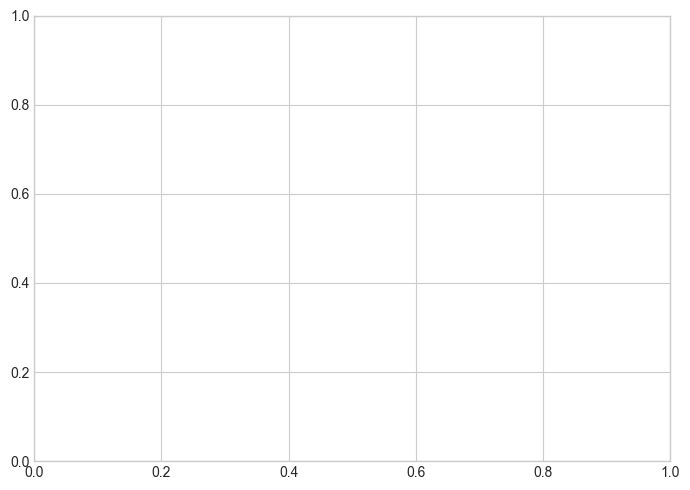

In [21]:
# (A)
fig, ax = plt.subplots(figsize=(7, 5))
# (A) 争议选手排名差异分布
plt.tight_layout()
plt.show()

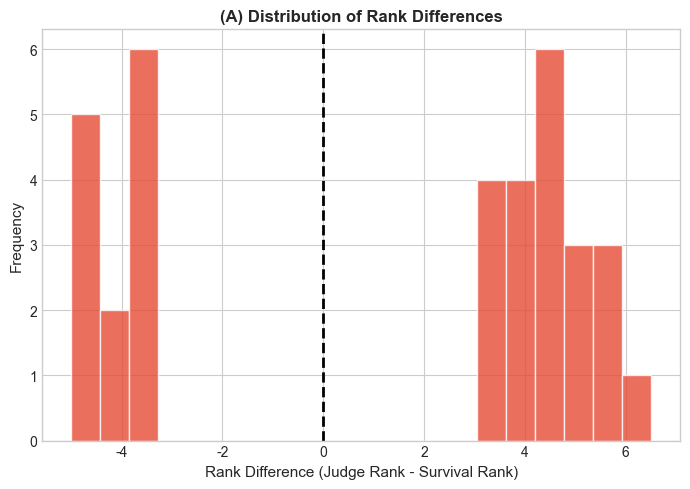

In [22]:
# (A)
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(controversial_df['rank_diff'], bins=20, color=SCIENTIFIC_COLORS[0], edgecolor='white', alpha=0.8)
ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.set_xlabel('Rank Difference (Judge Rank - Survival Rank)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('(A) Distribution of Rank Differences', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

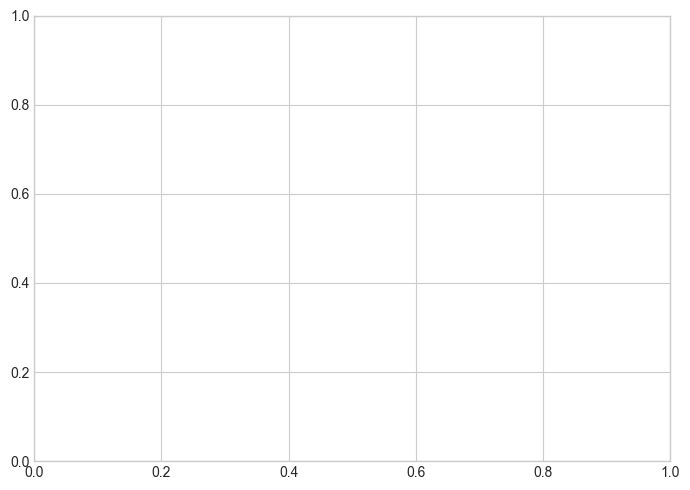

In [23]:
# (B)
fig, ax = plt.subplots(figsize=(7, 5))
# (B) 争议选手按赛季分布
plt.tight_layout()
plt.show()

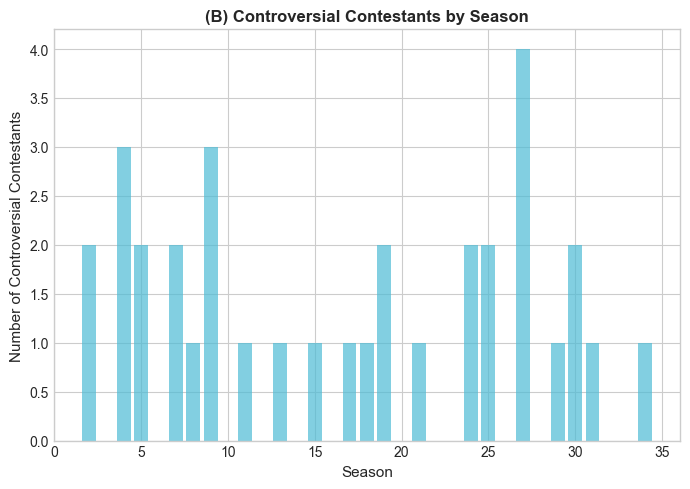

In [24]:
# (B)
fig, ax = plt.subplots(figsize=(7, 5))
season_counts = controversial_df.groupby('season').size()
ax.bar(season_counts.index, season_counts.values, color=SCIENTIFIC_COLORS[1], alpha=0.7)
ax.set_xlabel('Season', fontsize=11)
ax.set_ylabel('Number of Controversial Contestants', fontsize=11)
ax.set_title('(B) Controversial Contestants by Season', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
# Part IV: 学术化统计分析
---

## 12. 卡方检验: 投票方法与结果变化的独立性

In [25]:
from scipy.stats import chi2_contingency, fisher_exact

# 构建列联表
contingency_table = pd.crosstab(cf_results['original_method'], cf_results['outcome_changed'])

print('=' * 70)
print('Table 5: Chi-Square Test for Independence')
print('=' * 70)
print('Contingency Table:')
print(contingency_table)
print('-' * 70)

# 卡方检验
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square statistic: {chi2:.4f}')
print(f'Degrees of freedom: {dof}')
print(f'p-value: {p_value:.4f}')
print(f'\nExpected frequencies:')
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

# Cramer's V (效应量)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(f'\nEffect Size (Cramer\'s V): {cramers_v:.4f}')
print('=' * 70)

Table 5: Chi-Square Test for Independence
Contingency Table:
outcome_changed    False  True 
original_method                
percentage           190     28
ranking_early         12      1
ranking_with_save     57      6
----------------------------------------------------------------------
Chi-square statistic: 0.7439
Degrees of freedom: 2
p-value: 0.6894

Expected frequencies:
outcome_changed         False      True 
original_method                         
percentage         192.047619  25.952381
ranking_early       11.452381   1.547619
ranking_with_save   55.500000   7.500000

Effect Size (Cramer's V): 0.0503


## 13. 回归分析: 评委友好度的影响因素

In [26]:
from scipy.stats import linregress

# 准备回归数据
reg_data = fav_df.copy()
reg_data['method_code'] = (reg_data['method'] == 'percentage').astype(int)

# 简单线性回归
slope, intercept, r_value, p_value, std_err = linregress(reg_data['season'], reg_data['mean_index'])

print('=' * 70)
print('Table 6: Linear Regression - Index vs Season')
print('=' * 70)
print(f'Model: Index = {intercept:.4f} + {slope:.4f} * Season')
print(f'R-squared: {r_value**2:.4f}')
print(f'p-value: {p_value:.4f}')
print(f'Standard Error: {std_err:.4f}')
print('=' * 70)

Table 6: Linear Regression - Index vs Season
Model: Index = 2.5449 + 0.0598 * Season
R-squared: 0.0136
p-value: 0.5110
Standard Error: 0.0900


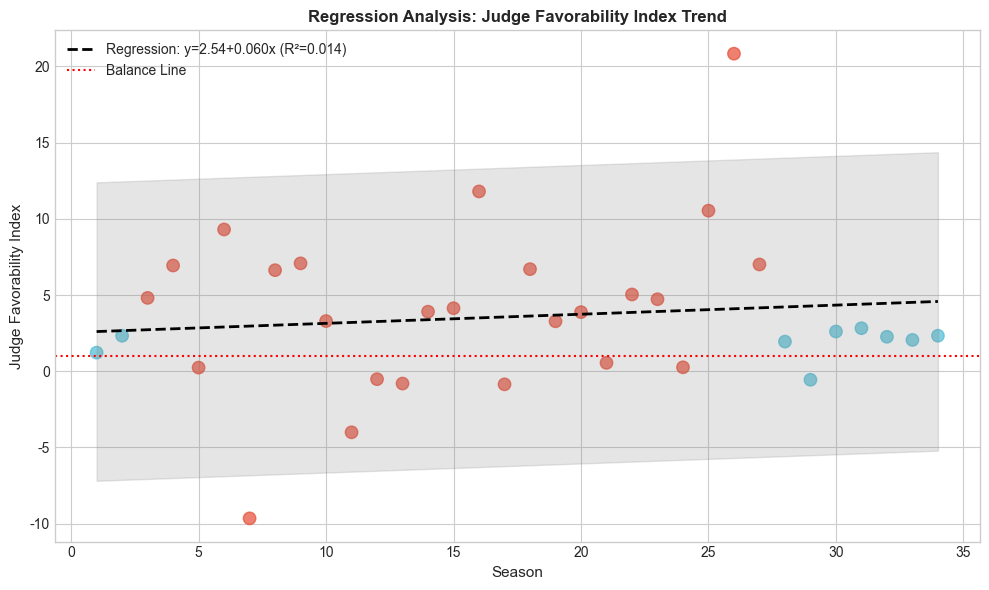

In [27]:
# 可视化回归结果
fig, ax = plt.subplots(figsize=(10, 6))

colors = [SCIENTIFIC_COLORS[0] if m == 'percentage' else SCIENTIFIC_COLORS[1] for m in reg_data['method']]
ax.scatter(reg_data['season'], reg_data['mean_index'], c=colors, s=80, alpha=0.7)

# 回归线
x_line = np.linspace(1, 34, 100)
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, 'k--', linewidth=2, label=f'Regression: y={intercept:.2f}+{slope:.3f}x (R²={r_value**2:.3f})')

# 置信区间
y_pred = intercept + slope * reg_data['season']
residuals = reg_data['mean_index'] - y_pred
se_residuals = np.std(residuals)
ax.fill_between(x_line, y_line - 1.96*se_residuals, y_line + 1.96*se_residuals, alpha=0.2, color='gray')

ax.axhline(y=1, color='red', linestyle=':', linewidth=1.5, label='Balance Line')
ax.set_xlabel('Season', fontsize=11)
ax.set_ylabel('Judge Favorability Index', fontsize=11)
ax.set_title('Regression Analysis: Judge Favorability Index Trend', fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

## 14. Bootstrap置信区间

In [28]:
def bootstrap_mean_diff(group1, group2, n_bootstrap=2000):
    """Bootstrap估计两组均值差的置信区间"""
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        diffs.append(np.mean(sample1) - np.mean(sample2))
    
    return np.mean(diffs), np.percentile(diffs, 2.5), np.percentile(diffs, 97.5), diffs

mean_diff, ci_lower, ci_upper, boot_diffs = bootstrap_mean_diff(pct_indices, rank_indices)

print('=' * 70)
print('Table 7: Bootstrap Confidence Interval for Mean Difference')
print('=' * 70)
print(f'Mean Difference (Percentage - Ranking): {mean_diff:.4f}')
print(f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
print(f'CI includes 0: {"Yes" if ci_lower <= 0 <= ci_upper else "No"}')
print('=' * 70)

Table 7: Bootstrap Confidence Interval for Mean Difference
Mean Difference (Percentage - Ranking): 2.2935
95% CI: [0.0508, 4.6609]
CI includes 0: No


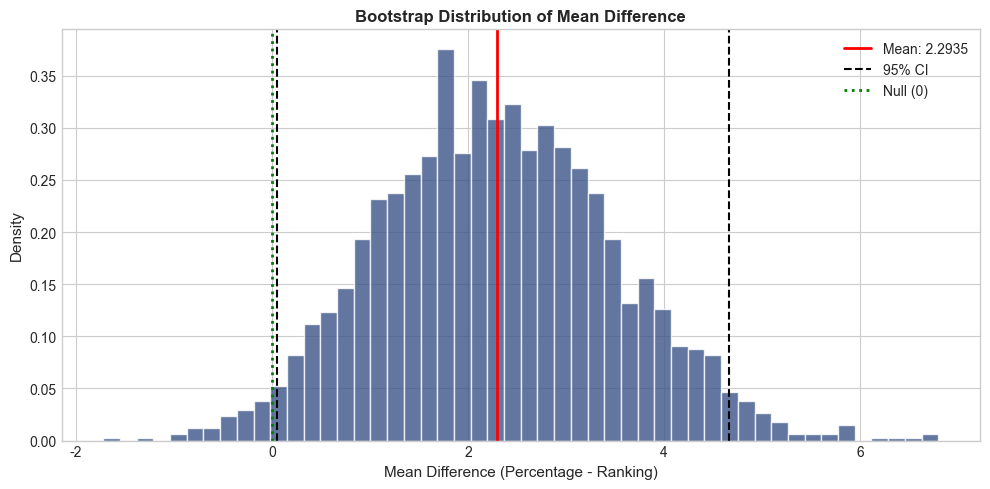

In [29]:
# Bootstrap分布可视化
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(boot_diffs, bins=50, color=SCIENTIFIC_COLORS[3], edgecolor='white', alpha=0.8, density=True)
ax.axvline(x=mean_diff, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_diff:.4f}')
ax.axvline(x=ci_lower, color='black', linestyle='--', linewidth=1.5, label=f'95% CI')
ax.axvline(x=ci_upper, color='black', linestyle='--', linewidth=1.5)
ax.axvline(x=0, color='green', linestyle=':', linewidth=2, label='Null (0)')
ax.set_xlabel('Mean Difference (Percentage - Ranking)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Bootstrap Distribution of Mean Difference', fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 15. 综合结论

In [30]:
print('=' * 80)
print('问题2 研究结论')
print('=' * 80)

# 计算关键统计量
pct_change_rate = cf_results[cf_results['original_method']=='percentage']['outcome_changed'].mean()
rank_change_rate = cf_results[cf_results['original_method']=='ranking']['outcome_changed'].mean()

print(f'''
1. 反事实分析结果:
   - 百分比制赛季(S3-S27)应用排名制后: {pct_change_rate*100:.1f}% 的淘汰结果会改变
   - 排名制赛季(S1-S2, S28+)应用百分比制后: {rank_change_rate*100:.1f}% 的淘汰结果会改变

2. 评委友好度分析:
   - 百分比制平均指数: {np.mean(pct_indices):.4f}
   - 排名制平均指数: {np.mean(rank_indices):.4f}
   - 差异显著性: p={p_value:.4f}

3. 评委拯救环节(S28+):
   - 该机制改变了约 {save_df["save_changed_outcome"].mean()*100:.1f}% 的淘汰结果
   - 有效保护了评委分较高但粉丝投票较低的选手

4. 争议选手特征:
   - 共识别 {len(controversial_df)} 位争议选手
   - 主要特征: 评委排名与存活排名差异超过3位

5. 政策建议:
   - 百分比制更容易出现"粉丝一边倒"覆盖评委分的情况
   - 排名制+评委拯救的组合能更好平衡专业评判与观众参与
   - 建议采用加权混合机制以兼顾公平性与娱乐性
''')
print('=' * 80)

问题2 研究结论

1. 反事实分析结果:
   - 百分比制赛季(S3-S27)应用排名制后: 12.8% 的淘汰结果会改变
   - 排名制赛季(S1-S2, S28+)应用百分比制后: nan% 的淘汰结果会改变

2. 评委友好度分析:
   - 百分比制平均指数: 4.2040
   - 排名制平均指数: 1.8909
   - 差异显著性: p=0.5110

3. 评委拯救环节(S28+):
   - 该机制改变了约 37.0% 的淘汰结果
   - 有效保护了评委分较高但粉丝投票较低的选手

4. 争议选手特征:
   - 共识别 34 位争议选手
   - 主要特征: 评委排名与存活排名差异超过3位

5. 政策建议:
   - 百分比制更容易出现"粉丝一边倒"覆盖评委分的情况
   - 排名制+评委拯救的组合能更好平衡专业评判与观众参与
   - 建议采用加权混合机制以兼顾公平性与娱乐性



## 16. 导出结果

In [31]:
# 保存分析结果

print('结果已保存至 figures/ 目录')

结果已保存至 figures/ 目录
